# Classification

In [243]:
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [198]:
df = pd.read_csv('customer-churn.csv')

In [199]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Cleaning

In [200]:
def standardise_colnames(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  return df

In [201]:
def standardise_str_cols(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()

  for col in df.columns:
    if is_object_dtype(df[col]):
      df[col] = df[col].str.lower().str.replace(' ', '_')
  
  return df

In [202]:
df = standardise_colnames(df)
df = standardise_str_cols(df)

In [203]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce').fillna(0)
df.churn = (df.churn == 'yes').astype('int')

In [204]:
df.drop('customerid', axis=1, inplace=True)

## Validation Framework

In [205]:
y = df.churn

In [206]:
df_train_full, df_test, y_train_full, y_test = train_test_split(
  df.drop('churn', axis=1), y, test_size=.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(
  df_train_full, y_train_full, test_size=.25, random_state=1)

In [207]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(4225, 19)
(1409, 19)
(1409, 19)


In [208]:
df_train_full.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

## Exploratory Data Analysis

In [209]:
df.isnull().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [210]:
df.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [211]:
global_churn_rate = round(df.churn.mean(), 2)
global_churn_rate

0.27

In [212]:
df.select_dtypes(exclude='number').nunique()

gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### Feature Importance
#### Churn Rate

In [213]:
df.groupby(['gender']).churn.agg(['mean', 'count']) / global_churn_rate # risk ratio

,mean,count
gender,,
female,0.997069,12918.518519
male,0.968901,13166.666667


In [214]:
df.groupby(['partner']).churn.agg(['mean', 'count']) / global_churn_rate # risk ratio

,mean,count
partner,,
no,1.220666,13485.185185
yes,0.728330,12600.000000


In [215]:
from IPython.display import display

In [216]:
categorical_vars = df.select_dtypes(exclude='number')

In [217]:
for c in categorical_vars:
  df_group = df.groupby(c).churn.agg(['mean', 'count'])
  df_group['diff'] = df_group['mean'] - global_churn_rate
  df_group['risk'] = df_group['mean'] / global_churn_rate
  display(df_group)
  print()

,mean,count,diff,risk
gender,,,,
female,0.269209,3488,-0.000791,0.997069
male,0.261603,3555,-0.008397,0.968901


,mean,count,diff,risk
partner,,,,
no,0.329580,3641,0.059580,1.220666
yes,0.196649,3402,-0.073351,0.728330


,mean,count,diff,risk
dependents,,,,
no,0.312791,4933,0.042791,1.158487
yes,0.154502,2110,-0.115498,0.572231


,mean,count,diff,risk
phoneservice,,,,
no,0.249267,682,-0.020733,0.923211
yes,0.267096,6361,-0.002904,0.989246


,mean,count,diff,risk
multiplelines,,,,
no,0.250442,3390,-0.019558,0.927565
no_phone_service,0.249267,682,-0.020733,0.923211
yes,0.286099,2971,0.016099,1.059626


,mean,count,diff,risk
internetservice,,,,
dsl,0.189591,2421,-0.080409,0.702189
fiber_optic,0.418928,3096,0.148928,1.551584
no,0.074050,1526,-0.195950,0.274259


,mean,count,diff,risk
onlinesecurity,,,,
no,0.417667,3498,0.147667,1.546916
no_internet_service,0.074050,1526,-0.195950,0.274259
yes,0.146112,2019,-0.123888,0.541155


,mean,count,diff,risk
onlinebackup,,,,
no,0.399288,3088,0.129288,1.478843
no_internet_service,0.074050,1526,-0.195950,0.274259
yes,0.215315,2429,-0.054685,0.797463


,mean,count,diff,risk
deviceprotection,,,,
no,0.391276,3095,0.121276,1.449171
no_internet_service,0.074050,1526,-0.195950,0.274259
yes,0.225021,2422,-0.044979,0.833410


,mean,count,diff,risk
techsupport,,,,
no,0.416355,3473,0.146355,1.542055
no_internet_service,0.074050,1526,-0.195950,0.274259
yes,0.151663,2044,-0.118337,0.561716


,mean,count,diff,risk
streamingtv,,,,
no,0.335231,2810,0.065231,1.241597
no_internet_service,0.074050,1526,-0.195950,0.274259
yes,0.300702,2707,0.030702,1.113711


,mean,count,diff,risk
streamingmovies,,,,
no,0.336804,2785,0.066804,1.247423
no_internet_service,0.074050,1526,-0.195950,0.274259
yes,0.299414,2732,0.029414,1.108942


,mean,count,diff,risk
contract,,,,
month-to-month,0.427097,3875,0.157097,1.581840
one_year,0.112695,1473,-0.157305,0.417390
two_year,0.028319,1695,-0.241681,0.104884


,mean,count,diff,risk
paperlessbilling,,,,
no,0.163301,2872,-0.106699,0.604818
yes,0.335651,4171,0.065651,1.243152


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.167098,1544,-0.102902,0.618883
credit_card_(automatic),0.152431,1522,-0.117569,0.564559
electronic_check,0.452854,2365,0.182854,1.677237
mailed_check,0.191067,1612,-0.078933,0.707656


### Mutual Information

In [218]:
from sklearn.metrics import mutual_info_score

In [219]:
mutual_info_score(df.churn, df.contract)

0.09845305342598898

In [220]:
def compute_churn_mutual_info(series: pd.Series) -> float:
  return mutual_info_score(df.churn, series)

In [221]:
mutual_scores = df.select_dtypes(exclude='number').apply(compute_churn_mutual_info)
mutual_scores.sort_values(ascending=False)

contract            0.098453
onlinesecurity      0.064677
techsupport         0.063021
internetservice     0.055574
onlinebackup        0.046792
paymentmethod       0.044519
deviceprotection    0.043917
streamingmovies     0.032001
streamingtv         0.031908
paperlessbilling    0.019194
dependents          0.014467
partner             0.011454
multiplelines       0.000801
phoneservice        0.000072
gender              0.000037
dtype: float64

### Correlation

In [222]:
def compute_churn_correlation(series):
  return series.corrwith(df.churn)

In [223]:
corrs = df.select_dtypes('number').corrwith(df.churn)
corrs.sort_values(ascending=False)

churn             1.000000
monthlycharges    0.193356
seniorcitizen     0.150889
totalcharges     -0.198324
tenure           -0.352229
dtype: float64

In [224]:
df[df.tenure <= 2].churn.mean()

0.5835266821345708

In [225]:
df[(df.tenure > 2) & (df.tenure <= 12)].churn.mean()

0.4033232628398791

In [226]:
df[df.tenure > 12].churn.mean()

0.17129915585752523

In [227]:
df[df.monthlycharges < 20].churn.mean()

0.08972267536704731

In [228]:
df[(df.monthlycharges >= 20) & (df.monthlycharges < 50)].churn.mean()

0.182034503271862

In [229]:
df[df.monthlycharges > 50].churn.mean()

0.3178752107925801

## Feature Preparation

In [230]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [231]:
X_train.shape

(4225, 45)

In [232]:
def encode_vars(df: pd.DataFrame, dv: DictVectorizer = None):
  df_dicts = df.to_dict(orient='records')

  if not dv:
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dicts)
  
  df_encoded = pd.DataFrame(
    data=dv.transform(df_dicts),
    columns=dv.get_feature_names_out()
  )

  return df_encoded, dv

In [233]:
df_train, dv = encode_categorical_vars(df_train)
df_val, _ = encode_categorical_vars(df_val, dv)

In [234]:
print(df_train.shape)
print(df_val.shape)

(4225, 45)
(1409, 45)


## Logistic Regression

In [235]:
model = LogisticRegression(max_iter=10000)
model.fit(df_train, y_train)

LogisticRegression(max_iter=10000)

In [236]:
y_pred_proba = model.predict_proba(df_val)[:,1]
y_pred = model.predict(df_val)

In [237]:
df_pred = pd.DataFrame({
  'probability': y_pred_proba,
  'prediction': y_pred,
  'actual': y_val,
  'correct': y_val == y_pred})

In [238]:
df_pred.correct.mean()

0.8034066713981547

In [239]:
model.predict_proba(df_val)

array([[0.99332322, 0.00667678],
       [0.79501693, 0.20498307],
       [0.78230552, 0.21769448],
       ...,
       [0.84841573, 0.15158427],
       [0.21090499, 0.78909501],
       [0.18824253, 0.81175747]])

## Model Evaluation
### Accuracy
Accuracy measures the proportion of correct predictions by the model over a set of input data points.

In [240]:
thresholds = np.linspace(0, 1, 21)

In [241]:
acc_scores = []

for threshold in thresholds:
  churn_prediction = (y_pred_proba >= threshold)
  acc = (y_val == churn_prediction).mean()
  acc_scores.append(acc)

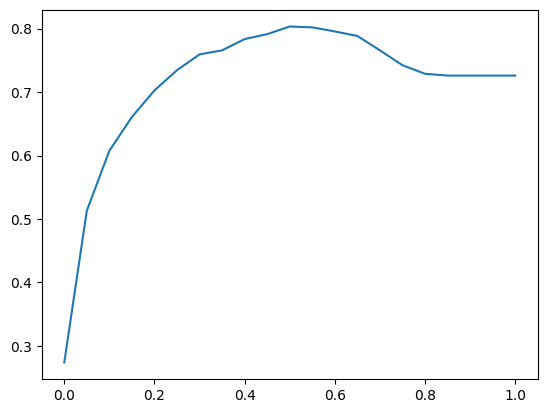

In [244]:
plt.plot(thresholds, acc_scores)